In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
def preprocess(df: pd.DataFrame):
    df = pl.from_pandas(df)
    new_features1 = [
        (pl.col('date_id') % 5).alias('day_of_week'),
        (pl.col('imbalance_buy_sell_flag') + 1).alias('imbalance_buy_sell_flag'),
        (pl.col('ask_price') - pl.col('bid_price')).alias('diff_ask_price_bid_price'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('diff_ask_price_reference_price'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('diff_bid_price_reference_price'),
        (pl.col('ask_price') - pl.col('wap')).alias('diff_ask_price_wap'),
        (pl.col('bid_price') - pl.col('wap')).alias('diff_bid_price_wap'),
        (pl.col('far_price') - pl.col('near_price')).alias('diff_far_price_near_price'),
        (pl.col('far_price') - pl.col('reference_price')).alias('diff_far_price_reference_price'),
        (pl.col('near_price') - pl.col('reference_price')).alias('diff_near_price_reference_price'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('diff_ask_size_bid_size'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('diff_ask_size_matched_size'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('diff_bid_size_matched_size'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('diff_imbalance_size_matched_size'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('sum_ask_price_bid_price'),
        (pl.col('far_price') + pl.col('near_price')).alias('sum_far_price_near_price'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('sum_ask_size_bid_size'),
        (pl.col('bid_size') * pl.col('ask_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor1'),
        (pl.col('ask_size') * pl.col('bid_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor2'),
        (pl.col('near_price') / pl.col('far_price')).alias('div_near_price_far_price'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature1'), 
        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature2'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature3'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature4'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature5'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature6'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature7'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature8'),
        ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature9'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature10'),
        ((pl.col('reference_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature11'),
        ((pl.col('reference_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature12'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature13'), 
        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature14'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('bid_size') - pl.col('imbalance_size'))).alias('feature15'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('imbalance_size') - pl.col('matched_size'))).alias('feature16'), 
        ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('bid_size') - pl.col('imbalance_size'))).alias('feature17'), 
        ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('matched_size') - pl.col('imbalance_size'))).alias('feature18'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature19'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature20'),
        ((pl.col('bid_size') - pl.col('matched_size')) / (pl.col('imbalance_size') - pl.col('matched_size'))).alias('feature21'),
        ((pl.col('bid_size') - pl.col('imbalance_size')) / (pl.col('matched_size') - pl.col('imbalance_size'))).alias('feature22'),
        ((pl.col('matched_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature23'),
        ((pl.col('matched_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature24'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature25'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature26'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature27'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature28'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature29'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature30'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature31'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature32'),
        (pl.col('imbalance_size') / pl.col('matched_size')).alias('feature33'),
        (pl.col('ask_size') / pl.col('imbalance_size')).alias('feature34'),
        (pl.col('bid_size') / pl.col('imbalance_size')).alias('feature35'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('ask_price') + pl.col('bid_price'))).alias('feature36'),
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('ask_price') + pl.col('reference_price'))).alias('feature37'),
        ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('bid_price') + pl.col('reference_price'))).alias('feature38'),
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('ask_price') + pl.col('wap'))).alias('feature39'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('bid_price') + pl.col('wap'))).alias('feature40'),
        ((pl.col('reference_price') - pl.col('wap')) / (pl.col('reference_price') + pl.col('wap'))).alias('feature41'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size'))).alias('feature42'),
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('ask_size') + pl.col('matched_size'))).alias('feature43'),
        ((pl.col('bid_size') - pl.col('matched_size')) / (pl.col('bid_size') + pl.col('matched_size'))).alias('feature44'),
        ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('ask_size') + pl.col('imbalance_size'))).alias('feature45'),
        ((pl.col('bid_size') - pl.col('imbalance_size')) / (pl.col('bid_size') + pl.col('imbalance_size'))).alias('feature46'),
        ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size'))).alias('feature47'),

        (pl.col('imbalance_size') * (pl.col('ask_price') - pl.col('bid_price'))).alias('feature48'),
        ((pl.col('ask_price') - pl.col('bid_price')) * (pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size'))).alias('feature49'),
        ((pl.col('ask_size') - pl.col('bid_size')) * (pl.col('far_price') - pl.col('bid_price'))).alias('feature50'),
    ]

    transform_features = [
        'imbalance_size',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
        'diff_ask_price_bid_price',
        'diff_ask_price_reference_price',
        'diff_bid_price_reference_price',
        'diff_ask_price_wap',
        'diff_bid_price_wap',
        'diff_far_price_near_price',
        'diff_far_price_reference_price',
        'diff_near_price_reference_price',
        'diff_ask_size_bid_size',
        'diff_ask_size_matched_size',
        'diff_bid_size_matched_size',
        'diff_imbalance_size_matched_size',
        'sum_ask_price_bid_price',
        'sum_far_price_near_price', 
        'wap_factor1',
        'wap_factor2',
        'feature1',
        'feature2',
        'feature3',
        'feature4',
        'feature5',
        'feature6',
        'feature7',
        'feature8',
        'feature9',
        'feature10',
        'feature11',
        'feature12',
        'feature13',
        'feature14',
        'feature15',
        'feature16',
        'feature17',
        'feature18',
        'feature19',
        'feature20',
        'feature21',
        'feature22',
        'feature23',
        'feature24',
        'feature25',
        'feature26',
        'feature27',
        'feature28',
        'feature29',
        'feature30',
        'feature31',
        'feature32',
        'feature33',
        'feature34',
        'feature35',
        'feature36',
        'feature37',
        'feature38',
        'feature39',
        'feature40',
        'feature41',
        'feature42',
        'feature43',
        'feature44',
        'feature45',
        'feature46',
        'feature47',
        'feature48',
        'feature49',
        'feature50',
    ]

    new_features2 = [
        ((pl.col(feature) - pl.col(feature).quantile(0.5)) / (pl.col(feature).quantile(0.75) - pl.col(feature).quantile(0.25)))
        .over(['date_id', 'seconds_in_bucket'])
        .alias(f'robust_scaled_{feature}_over_stocks')
        for feature in transform_features
    ]

    new_features3 = [
        pl.col('wap').mean().over(['date_id', 'seconds_in_bucket']).alias(f'mean_wap_over_stocks'),
    ]
    
    df = (
        df
        .with_columns(new_features1)
        .with_columns(new_features2)
        .with_columns(new_features3)
        .drop(['row_id'])
        .to_pandas()
    )
    return df

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['time_id'], inplace=True)
train_df = preprocess(train_df)
train_df = train_df.dropna(subset=['target'])
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,day_of_week,diff_ask_price_bid_price,diff_ask_price_reference_price,diff_bid_price_reference_price,diff_ask_price_wap,diff_bid_price_wap,diff_far_price_near_price,diff_far_price_reference_price,diff_near_price_reference_price,diff_ask_size_bid_size,diff_ask_size_matched_size,diff_bid_size_matched_size,diff_imbalance_size_matched_size,sum_ask_price_bid_price,sum_far_price_near_price,sum_ask_size_bid_size,wap_factor1,wap_factor2,div_near_price_far_price,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,robust_scaled_imbalance_size_over_stocks,robust_scaled_reference_price_over_stocks,robust_scaled_matched_size_over_stocks,robust_scaled_far_price_over_stocks,robust_scaled_near_price_over_stocks,robust_scaled_bid_price_over_stocks,robust_scaled_bid_size_over_stocks,robust_scaled_ask_price_over_stocks,robust_scaled_ask_size_over_stocks,robust_scaled_wap_over_stocks,robust_scaled_diff_ask_price_bid_price_over_stocks,robust_scaled_diff_ask_price_reference_price_over_stocks,robust_scaled_diff_bid_price_reference_price_over_stocks,robust_scaled_diff_ask_price_wap_over_stocks,robust_scaled_diff_bid_price_wap_over_stocks,robust_scaled_diff_far_price_near_price_over_stocks,robust_scaled_diff_far_price_reference_price_over_stocks,robust_scaled_diff_near_price_reference_price_over_stocks,robust_scaled_diff_ask_size_bid_size_over_stocks,robust_scaled_diff_ask_size_matched_size_over_stocks,robust_scaled_diff_bid_size_matched_size_over_stocks,robust_scaled_diff_imbalance_size_matched_size_over_stocks,robust_scaled_sum_ask_price_bid_price_over_stocks,robust_scaled_sum_far_price_near_price_over_stocks,robust_scaled_wap_factor1_over_stocks,robust_scaled_wap_factor2_over_stocks,robust_scaled_feature1_over_stocks,robust_scaled_feature2_over_stocks,robust_scaled_feature3_over_stocks,robust_scaled_feature4_over_stocks,robust_scaled_feature5_over_stocks,robust_scaled_feature6_over_stocks,robust_scaled_feature7_over_stocks,robust_scaled_feature8_over_stocks,robust_scaled_feature9_over_stocks,robust_scaled_feature10_over_stocks,robust_scaled_feature11_over_stocks,robust_scaled_feature12_over_stocks,robust_scaled_feature13_over_stocks,robust_scaled_feature14_over_stocks,robust_scaled_feature15_over_stocks,robust_scaled_feature16_over_stocks,robust_scaled_feature17_over_stocks,robust_scaled_feature18_over_stocks,robust_scaled_feature19_over_stocks,robust_scaled_feature20_over_stocks,robust_scaled_feature21_over_stocks,robust_scaled_feature22_over_stocks,robust_scaled_feature23_over_stocks,robust_scaled_feature24_over_stocks,robust_scaled_feature25_over_stocks,robust_scaled_feature26_over_stocks,robust_scaled_feature27_over_stocks,robust_scaled_feature28_over_stocks,robust_scaled_feature29_over_stocks,robust_scaled_feature30_over_stocks,robust_scaled_feature31_over_stocks,robust_scaled_feature32_over_stocks,robust_scaled_feature33_over_stocks,robust_scaled_feature34_over_stocks,robust_scaled_feature35_over_stocks,robust_scaled_feature36_over_stocks,robust_scaled_feature37_over_stocks,robust_scaled_feature38_over_stocks,robust_scaled_feature39_over_stocks,robust_scaled_feature40_over_stocks,robust_scaled_feature41_over_stocks,robust_scaled_feature42_over_stocks,robust_scaled_feature43_over_stocks,robust_scaled_feature44_over_stocks,robust_scaled_feature45_over_stocks,robust_scaled_feature46_over_stocks,robust_scaled_feature47_over_stocks,robust_scaled_fe

## train lightgbm models using cross validation

In [4]:
def train(
        dataset: pd.DataFrame,
        params: Dict[str, Any],
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    valid_days = days[-60:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]

    train_day_limits = [(360, 420), (300, 420), (240, 420), (180, 420), (120, 420), (60, 420), (0, 420)]

    for k, limits in enumerate(train_day_limits):
        train_days = np.arange(*limits)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns].iloc[:1024]
        train_y = dataset.query('date_id in @train_days')[target_columns].iloc[:1024]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')

        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(
            train_X,
            train_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )

        valid_dataset = lgb.Dataset(
            valid_X,
            valid_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_fold{k+1}.txt'),
            num_iteration=model.best_iteration
        )
        
        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X, num_iteration=model.best_iteration)
        valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)

        valid_y[f'regression_fold{k+1}'] = valid_pred

        history['train_mae'].append(mean_absolute_error(train_y['target'], train_pred))
        history['valid_mae'].append(mean_absolute_error(valid_y['target'], valid_pred))
        
        del train_X, train_y, train_dataset, valid_dataset, model, fimp
        del train_pred, valid_pred
        gc.collect()

    del valid_X
    gc.collect()

    history = pd.DataFrame.from_dict(history)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    
    valid_y['regression'] = valid_y[[f'regression_fold{k+1}' for k in range(len(train_day_limits))]].mean(axis=1)
    test_y_mae = mean_absolute_error(valid_y['target'], valid_y['regression'])
    print(f'test_y mae: {test_y_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'param_records': params,
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return history, valid_y, fimps


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), valid_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

fold 1
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419]
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479]


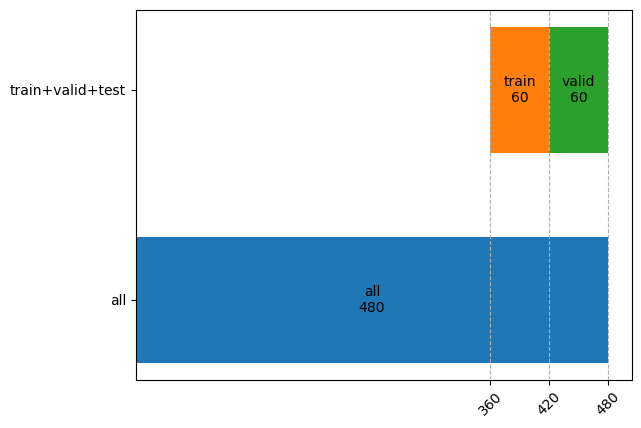

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 4)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 6.13538	valid's l1: 6.27551
Early stopping, best iteration is:
[3]	train's l1: 6.34542	valid's l1: 6.26678
fold 2
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371
 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389
 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407
 408 409 410 411 412 413 414 415 416 417 418 419]
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 4

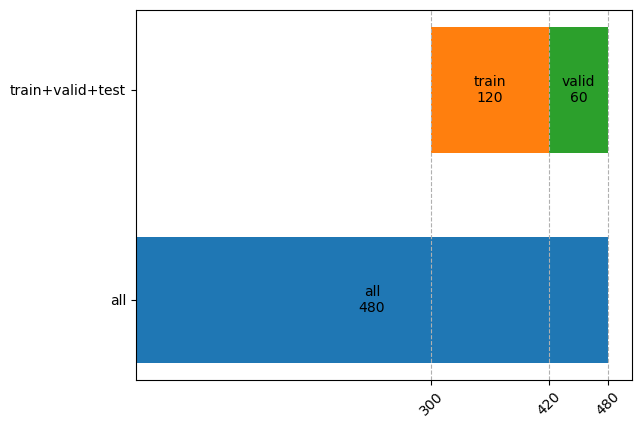

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 5)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 6.46863	valid's l1: 5.86969
[200]	train's l1: 6.25705	valid's l1: 5.86796
Early stopping, best iteration is:
[175]	train's l1: 6.30856	valid's l1: 5.86669
fold 3
[240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399

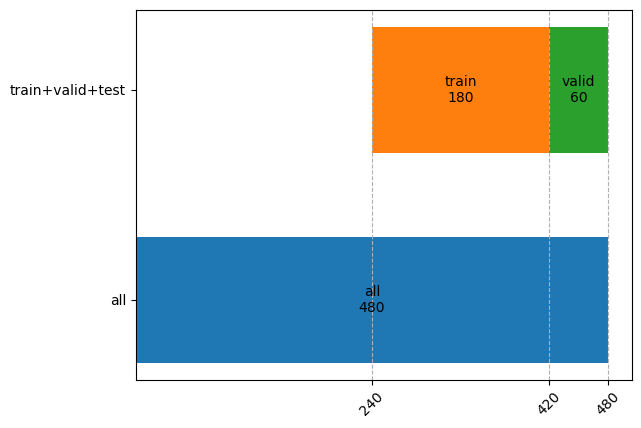

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 6)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 6.4842	valid's l1: 5.93364
[200]	train's l1: 6.27592	valid's l1: 5.92967
[300]	train's l1: 6.08838	valid's l1: 5.93343
Early stopping, best iteration is:
[236]	train's l1: 6.20242	valid's l1: 5.92834
fold 4
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 32

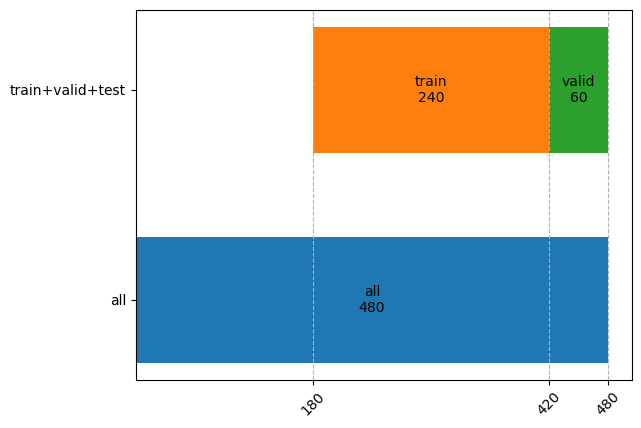

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 7)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 6.33526	valid's l1: 6.19733
[200]	train's l1: 6.1362	valid's l1: 6.19369
Early stopping, best iteration is:
[166]	train's l1: 6.19918	valid's l1: 6.19147
fold 5
[120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 

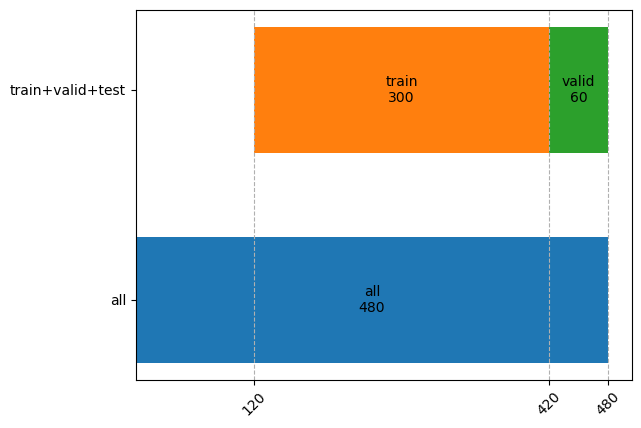

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 8)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 9.05647	valid's l1: 5.86859
[200]	train's l1: 8.76356	valid's l1: 5.86441
[300]	train's l1: 8.49599	valid's l1: 5.8651
Early stopping, best iteration is:
[250]	train's l1: 8.62766	valid's l1: 5.86265
fold 6
[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 20

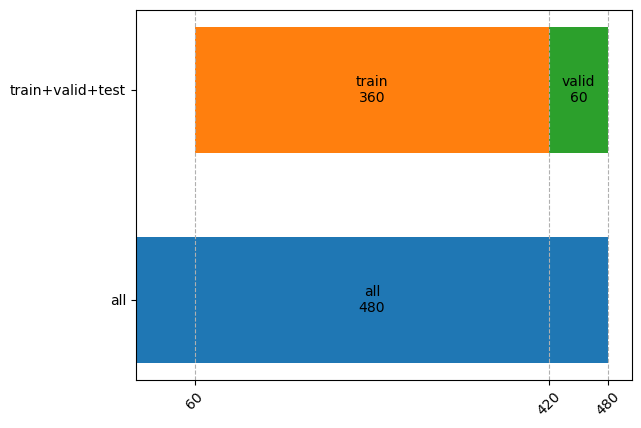

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 9)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 5.40837	valid's l1: 6.04379
Early stopping, best iteration is:
[1]	train's l1: 5.58475	valid's l1: 6.04319
fold 7
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 17

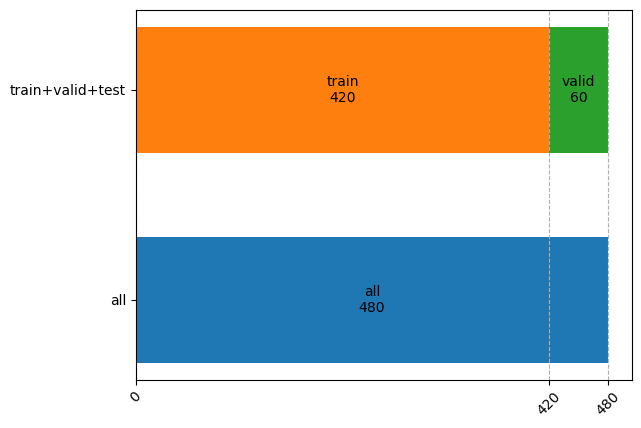

train_X.shape: (1024, 159), train_y.shape: (1024, 4)
valid_X.shape: (659999, 159), valid_y.shape: (659999, 10)
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 6.21151	valid's l1: 5.8308
[200]	train's l1: 6.02555	valid's l1: 5.82768
[300]	train's l1: 5.85172	valid's l1: 5.83007
Early stopping, best iteration is:
[220]	train's l1: 5.99071	valid's l1: 5.82742
test_y mae: 5.8349


In [5]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': 'mae',
    'learning_rate':1e-03,
    'seed': 42,
    'max_depth':  10,
    'num_leaves': 256,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.0,
    'feature_fraction_bynode': 1.0,
    'lambda_l2': 0.0,
    #'bagging_fraction': 0.6,
    'verbose': -1,
}

history, result, fimps = train(
    dataset=train_df,
    params=params,
    outputs_dir=outputs_dir_path,
)

,stock_id,date_id,seconds_in_bucket,target,regression_fold1,regression_fold2,regression_fold3,regression_fold4,regression_fold5,regression_fold6,regression_fold7,regression
4566980,0,420,0,-2.239943,2.474710,-1.272874,-0.920121,2.665403,-1.306830,1.698826,-0.401760,0.419622
4566981,1,420,0,25.689602,2.484210,-0.447938,-1.444600,2.246162,-0.530697,1.697726,0.076639,0.583072
4566982,2,420,0,-2.110004,2.484210,-2.445411,-1.075224,1.731888,-2.375714,1.695551,-0.680986,-0.095098
4566983,3,420,0,-4.789829,2.479504,-0.228256,-1.507439,2.741691,-1.430729,1.692151,-0.647303,0.442803
4566984,4,420,0,-3.380179,2.482698,-1.306455,-1.350964,1.915444,-0.703291,1.692151,-0.902247,0.261048
...,...,...,...,...,...,...,...,...,...,...,...,...
5226975,195,479,540,1.599789,2.483895,-0.649696,-1.834693,2.366943,-0.863486,1.695881,0.284791,0.497662
5226976,196,479,540,-8.440018,2.483792,-0.686170,-1.042044,2.349979,-0.724598,1.698826,-0.294434,0.540764
5226977,197,479,540,5.149841,2.481169,-1.374338,-1.597338,2.613505,-0.674040,1.692451,-0.154028,0.426769
5226978,198,479,540,-0.249743,2.482832,-0.297710,-1.002221,2.451101,-0.600789,1.694942,0.220530,0.706955


,fold1,fold2,fold3,fold4,fold5,fold6,fold7,mean_fimps,std_fimps
robust_scaled_feature32_over_stocks,0.000000,19.577850,499.147980,289.794110,1103.806734,0.000000,716.657478,375.569165,423.897489
feature35,0.000000,659.078717,775.055151,97.259929,663.556490,0.000000,491.753812,383.814871,340.462131
robust_scaled_feature41_over_stocks,0.000000,9.750810,899.972788,611.996029,858.065155,0.000000,394.191553,396.282333,403.519973
feature32,0.000000,332.340338,308.052866,1094.154952,564.051147,0.000000,504.638858,400.462595,376.993319
robust_scaled_diff_bid_price_wap_over_stocks,0.000000,221.139560,298.420713,625.053135,944.777189,0.000000,799.406049,412.685235,380.381233
robust_scaled_diff_ask_size_matched_size_over_stocks,0.000000,650.267506,136.565859,1299.494745,2.453330,0.000000,898.208541,426.712854,526.368413
robust_scaled_feature10_over_stocks,0.000000,2636.329434,124.406897,66.315122,295.881938,13.499650,39.792060,453.746443,967.662009
feature13,0.000000,29.656289,37.690969,1809.170628,635.806696,0.000000,714.788908,461.016213,671.170639
feature41,0.000000,509.862113,322.778917,912.829779,460.849203,0.000000,1151.254920,479.653562,432.955139
ask_size,0.000000,397.482505,446.657162,651.391316,1052.658059,0.000000,823.021673,481.601531,396.585222


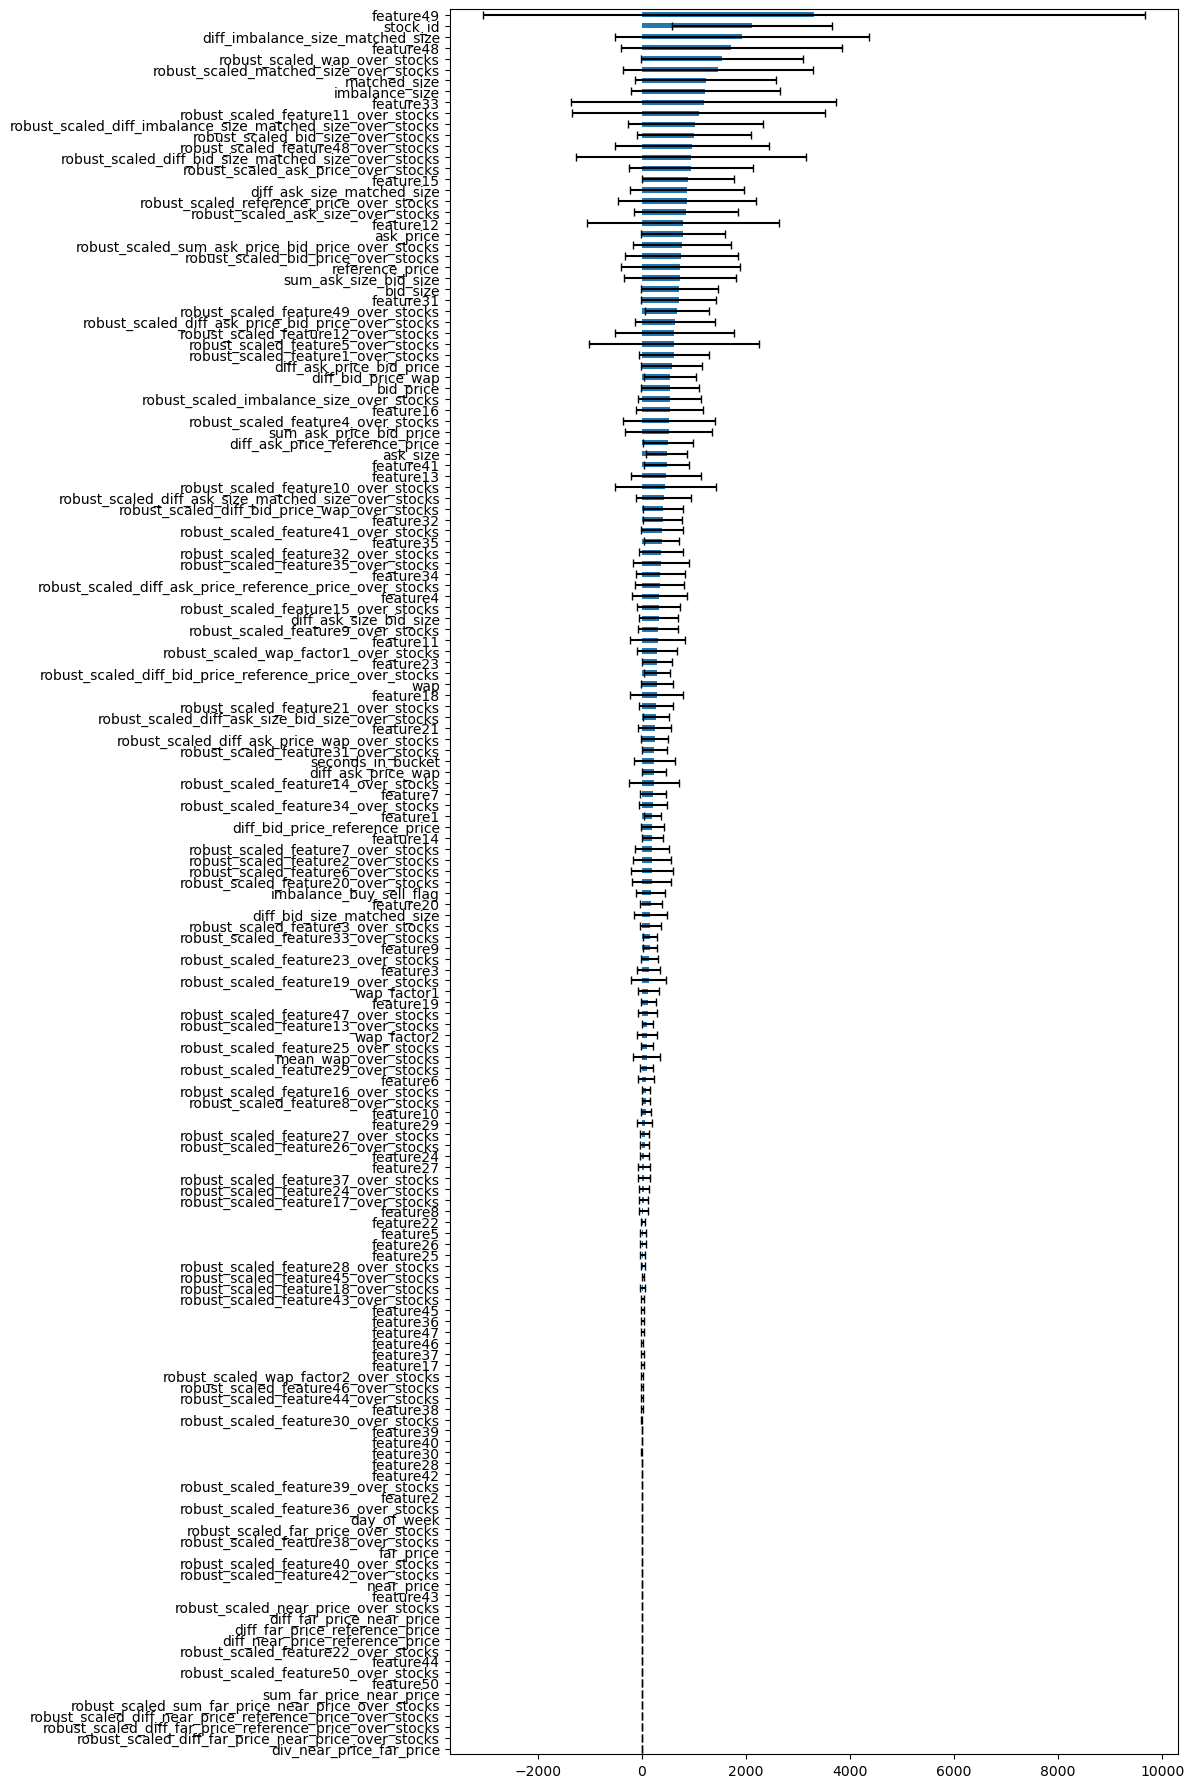

Index(['div_near_price_far_price',
       'robust_scaled_diff_far_price_near_price_over_stocks',
       'robust_scaled_diff_far_price_reference_price_over_stocks',
       'robust_scaled_diff_near_price_reference_price_over_stocks',
       'robust_scaled_sum_far_price_near_price_over_stocks',
       'sum_far_price_near_price', 'feature50',
       'robust_scaled_feature50_over_stocks', 'feature44',
       'robust_scaled_feature22_over_stocks',
       'diff_near_price_reference_price', 'diff_far_price_reference_price',
       'diff_far_price_near_price', 'robust_scaled_near_price_over_stocks',
       'feature43', 'near_price', 'robust_scaled_feature42_over_stocks',
       'robust_scaled_feature40_over_stocks', 'far_price',
       'robust_scaled_feature38_over_stocks',
       'robust_scaled_far_price_over_stocks', 'day_of_week',
       'robust_scaled_feature36_over_stocks', 'feature2',
       'robust_scaled_feature39_over_stocks', 'feature42', 'feature28',
       'feature30', 'feature40', 

In [6]:
display(result)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(12, 18))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()

fimps_quantile_th = fimps['mean_fimps'].quantile(q=0.2)
display(fimps.query('mean_fimps < @fimps_quantile_th').index)

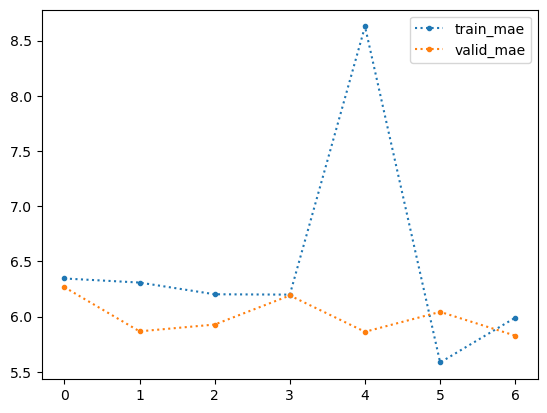

In [7]:
history.plot(marker='.', linestyle=':')
plt.show()

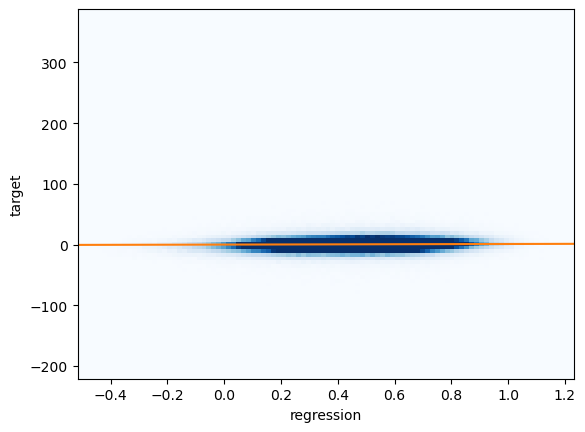

correlation coeeficient: 0.1000


In [8]:
_, ax = plt.subplots()
ax.hist2d(result['regression'], result['target'], bins=100, cmap='Blues', vmax=1e+03)
ax.plot([-100, 100], [-100, 100], color='tab:orange')
ax.set_xlabel('regression')
ax.set_ylabel('target')
plt.show()

r = np.corrcoef(result['regression'], result['target'])
print(f'correlation coeeficient: {r[0, 1]:.4f}')

## train lightgbm model using all data

In [9]:
target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
feature_columns = [col for col in train_df.columns if col not in ['date_id', 'target']]

callbacks = [
    lgb.log_evaluation(100),
]

train_dataset = lgb.Dataset(
    train_df[feature_columns],
    train_df[target_columns]['target'],
)

del train_df
gc.collect()

model = lgb.train(
    params=params,
    train_set=train_dataset,
    callbacks=callbacks,
    num_boost_round=3000,
)

model.save_model(
    outputs_dir_path.joinpath(f'lightgbm_trained_using_alldata.txt'),
    num_iteration=model.best_iteration
)

KeyboardInterrupt: 